In [287]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from scipy.stats import chi2_contingency

from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV
from lightgbm import LGBMClassifier

from sklearn.metrics import roc_auc_score
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
from sklearn.inspection import permutation_importance


# 분류 : 통신사 Churn

In [288]:
orig_train_df = pd.read_csv("./data/real_world_data/churn_train.csv")
orig_test_df = pd.read_csv("./data/real_world_data/churn_test.csv")

df = orig_train_df.copy()
df.head()

,Customer_ID,Age,Tenure_Months,Monthly_Fee,Total_Usage_GB,Support_Tickets_3M,Late_Payments_6M,Contract,AutoPay,Internet_Type,Has_Addon,NPS_Score,Region,Churn
0,22216,38,1,70096,449,1,0,Month-to-month,1,DSL,1,-57,Seoul,0
1,22583,33,11,38262,564,2,1,Month-to-month,0,Fiber,0,69,Seoul,1
2,21663,27,34,62086,362,1,0,Month-to-month,1,Fiber,1,21,Metro,1
3,23028,56,19,72615,595,0,0,1-year,0,DSL,0,16,Seoul,0
4,24344,31,62,63279,365,2,1,2-year,0,5G,0,13,Metro,0


In [289]:
df = orig_train_df.drop("Customer_ID", axis=1)
test_df = orig_test_df.drop("Customer_ID", axis=1)

df.info()

<class 'pandas.DataFrame'>
RangeIndex: 6400 entries, 0 to 6399
Data columns (total 13 columns):
 #   Column              Non-Null Count  Dtype
---  ------              --------------  -----
 0   Age                 6400 non-null   int64
 1   Tenure_Months       6400 non-null   int64
 2   Monthly_Fee         6400 non-null   int64
 3   Total_Usage_GB      6400 non-null   int64
 4   Support_Tickets_3M  6400 non-null   int64
 5   Late_Payments_6M    6400 non-null   int64
 6   Contract            6400 non-null   str  
 7   AutoPay             6400 non-null   int64
 8   Internet_Type       6400 non-null   str  
 9   Has_Addon           6400 non-null   int64
 10  NPS_Score           6400 non-null   int64
 11  Region              6400 non-null   str  
 12  Churn               6400 non-null   int64
dtypes: int64(10), str(3)
memory usage: 650.1 KB


<Axes: ylabel='Frequency'>

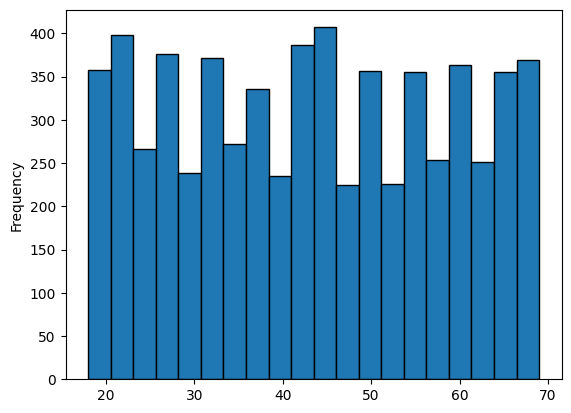

In [290]:
df["Age"].plot(kind="hist", bins=20, edgecolor="black")

<Axes: ylabel='Frequency'>

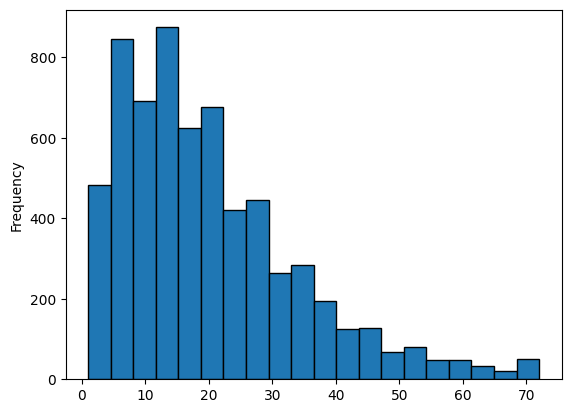

In [291]:
df["Tenure_Months"].plot(kind="hist", bins=20, edgecolor="black")

<Axes: ylabel='Frequency'>

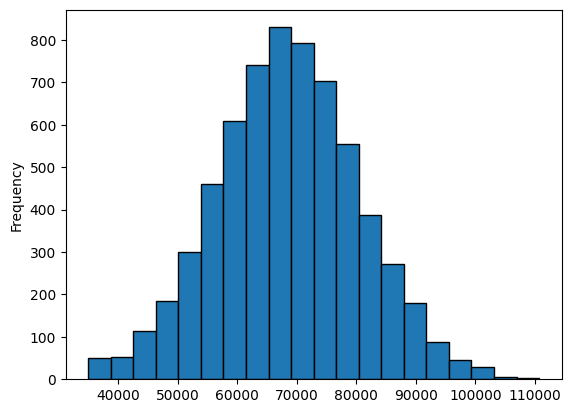

In [292]:
df["Monthly_Fee"].plot(kind="hist", bins=20, edgecolor="black")

<Axes: ylabel='Frequency'>

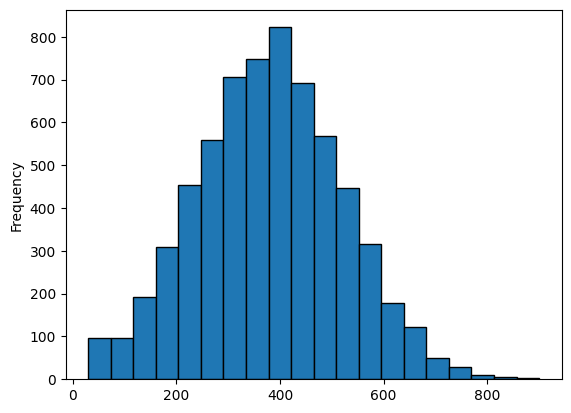

In [293]:
df["Total_Usage_GB"].plot(kind="hist", bins=20, edgecolor="black")

<Axes: ylabel='Frequency'>

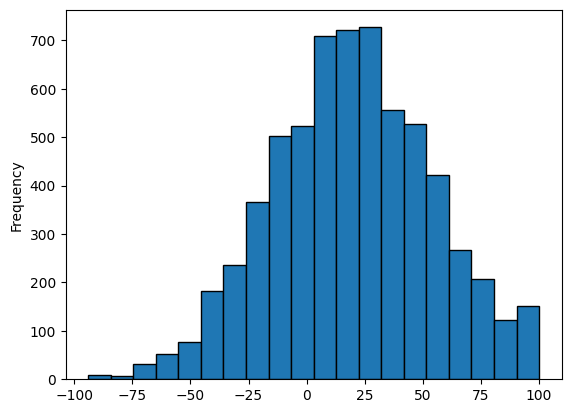

In [294]:
df["NPS_Score"].plot(kind="hist", bins=20, edgecolor="black")

In [295]:
df["Contract"].unique()

<StringArray>
['Month-to-month', '1-year', '2-year']
Length: 3, dtype: str

In [296]:
df["Contract"].value_counts()

Contract
Month-to-month    3493
1-year            1975
2-year             932
Name: count, dtype: int64

In [297]:
df.groupby("Contract")["Churn"].mean()

Contract
1-year            0.176203
2-year            0.114807
Month-to-month    0.345262
Name: Churn, dtype: float64

In [298]:
df.groupby("AutoPay")["Churn"].mean()

AutoPay
0    0.338930
1    0.195425
Name: Churn, dtype: float64

In [299]:
df.groupby("Support_Tickets_3M")["Churn"].mean()

Support_Tickets_3M
0    0.219780
1    0.263979
2    0.325000
3    0.374016
4    0.437500
5    0.333333
6    1.000000
Name: Churn, dtype: float64

In [300]:
df.groupby("Late_Payments_6M")["Churn"].mean()

Late_Payments_6M
0    0.212592
1    0.299902
2    0.415800
3    0.487805
4    0.571429
Name: Churn, dtype: float64

In [301]:
df.groupby("Internet_Type")["Churn"].mean()

Internet_Type
5G       0.274725
DSL      0.243298
Fiber    0.263576
Name: Churn, dtype: float64

In [302]:
df.groupby("Region")["Churn"].mean()

Region
Metro    0.259524
Other    0.261357
Seoul    0.258124
Name: Churn, dtype: float64

In [303]:
df["Churn"].mean()  # 상관이 없을 가능성이 높음.

## 데이터 불균형이 있다. (0이 1보다 많음) -> 하지만 실제 세상(test) 또한 0이 1보다 더 많다면(비율이 같다면)
## 그대로 학습한다.

np.float64(0.25953125)

In [304]:
## 데이터 불균형 확인
df["Churn"].value_counts()

Churn
0    4739
1    1661
Name: count, dtype: int64

In [305]:

from scipy.stats import chi2_contingency

contingency = pd.crosstab(df["Region"], df["Churn"])

chi2, p, dof, expected = chi2_contingency(contingency)

n = contingency.sum().sum()
k = min(contingency.shape)

cramers_v = np.sqrt(chi2 / (n * (k - 1)))

print("Cramér’s V:", cramers_v)

# Region과 Internet_Type은 각각 churn와 직접적인 상관이 없을 수 있지만
# 다변량 문제에서는 변수가 다른 변수에 영향을 줄 수 있기 때문에 섣불리 제거하면 안된다.
# Internet_Type + Contract -> strong predictor

## Cramér’s V는 linear / marginal dependency만 측정.
## Tree model은 nonlinear + interaction 학습.

Cramér’s V: 0.0028484979487982467


In [306]:
# Predictor 파워가 없음을 확인하였고 Region, Internet_Type열을 제거해준다.
cols_to_drop = "Region"

#df = df.drop(cols_to_drop, axis=1)
#test_df = test_df.drop(cols_to_drop, axis=1)

In [307]:
df.head()

,Age,Tenure_Months,Monthly_Fee,Total_Usage_GB,Support_Tickets_3M,Late_Payments_6M,Contract,AutoPay,Internet_Type,Has_Addon,NPS_Score,Region,Churn
0,38,1,70096,449,1,0,Month-to-month,1,DSL,1,-57,Seoul,0
1,33,11,38262,564,2,1,Month-to-month,0,Fiber,0,69,Seoul,1
2,27,34,62086,362,1,0,Month-to-month,1,Fiber,1,21,Metro,1
3,56,19,72615,595,0,0,1-year,0,DSL,0,16,Seoul,0
4,31,62,63279,365,2,1,2-year,0,5G,0,13,Metro,0


In [309]:
cols_to_std = ["Age", "Tenure_Months", "Monthly_Fee", "Total_Usage_GB", "NPS_Score"]
cols_to_reg = ["Support_Tickets_3M", "Late_Payments_6M"]
cols_to_onehot = ["Internet_Type", "Region"]
cols_to_label = "Contract"
cat_cols = df.select_dtypes(include=["str", "category"]).columns.tolist()

In [310]:
df = pd.get_dummies(df, columns=cols_to_onehot, drop_first=False)
test_df = pd.get_dummies(test_df, columns=cols_to_onehot, drop_first=False)
#df.head()

In [311]:
## Tree 기반 모델은 스케일링하지 않는게 좋겠다..

# LabelEncoder를 사용하지 않는 이유 : Magnitude가 있다는 것을 위에서 확인하여 
# 정규화 스케일링으로 데이터가 연속성을 띄게 하려고하는데, LabelEncoder는 순서를 알파벳순으로 변환하기 때문에
# 이렇게 직접 순서를 변환하였다. 

label_dict = {
    "Month-to-month":0,
    "1-year":1,
    "2-year":2
}

df[cols_to_label] = df[cols_to_label].map(label_dict)
test_df[cols_to_label] = test_df[cols_to_label].map(label_dict)

df.head()

,Age,Tenure_Months,Monthly_Fee,Total_Usage_GB,Support_Tickets_3M,Late_Payments_6M,Contract,AutoPay,Has_Addon,NPS_Score,Churn,Internet_Type_5G,Internet_Type_DSL,Internet_Type_Fiber,Region_Metro,Region_Other,Region_Seoul
0,38,1,70096,449,1,0,0,1,1,-57,0,False,True,False,False,False,True
1,33,11,38262,564,2,1,0,0,0,69,1,False,False,True,False,False,True
2,27,34,62086,362,1,0,0,1,1,21,1,False,False,True,True,False,False
3,56,19,72615,595,0,0,1,0,0,16,0,False,True,False,False,False,True
4,31,62,63279,365,2,1,2,0,0,13,0,True,False,False,True,False,False


In [312]:
df["Contract_Tenure"] = df["Contract"] * df["Tenure_Months"]
test_df["Contract_Tenure"] = test_df["Contract"] * test_df["Tenure_Months"]

df["Payment_Risk"] = (df["Late_Payments_6M"] / (df["Tenure_Months"] + 1))
test_df["Payment_Risk"] = (test_df["Late_Payments_6M"] / (test_df["Tenure_Months"] + 1))

df["Fee_per_Usage"] = (df["Monthly_Fee"] / (df["Total_Usage_GB"] + 1))
test_df["Fee_per_Usage"] = (test_df["Monthly_Fee"] / (test_df["Total_Usage_GB"] + 1))

In [313]:
## tree 기반 모델은 스케일링이 의미가 없기 때문에 안함

#std_scaler = StandardScaler()
#reg_scaler = MinMaxScaler()

#df[cols_to_std] = std_scaler.fit_transform(df[cols_to_std])
#df[cols_to_reg] = reg_scaler.fit_transform(df[cols_to_reg])

#test_df[cols_to_std] = std_scaler.transform(test_df[cols_to_std])
#test_df[cols_to_reg] = reg_scaler.transform(test_df[cols_to_reg])

print(df.shape)
df.head()

(6400, 20)


,Age,Tenure_Months,Monthly_Fee,Total_Usage_GB,Support_Tickets_3M,Late_Payments_6M,Contract,AutoPay,Has_Addon,NPS_Score,Churn,Internet_Type_5G,Internet_Type_DSL,Internet_Type_Fiber,Region_Metro,Region_Other,Region_Seoul,Contract_Tenure,Payment_Risk,Fee_per_Usage
0,38,1,70096,449,1,0,0,1,1,-57,0,False,True,False,False,False,True,0,0.000000,155.768889
1,33,11,38262,564,2,1,0,0,0,69,1,False,False,True,False,False,True,0,0.083333,67.720354
2,27,34,62086,362,1,0,0,1,1,21,1,False,False,True,True,False,False,0,0.000000,171.035813
3,56,19,72615,595,0,0,1,0,0,16,0,False,True,False,False,False,True,19,0.000000,121.837248
4,31,62,63279,365,2,1,2,0,0,13,0,True,False,False,True,False,False,124,0.015873,172.893443


In [314]:
X = df.drop("Churn", axis=1)
y = df["Churn"]

X_test = test_df.drop("Churn", axis=1)
y_test = test_df["Churn"]

In [317]:
'''
model = LGBMClassifier(
    n_estimators=5000,
    learning_rate=0.01,
    num_leaves=64,
    max_depth=-1,
    min_child_samples=10,
    subsample=0.8,
    colsample_bytree=0.8,
    reg_alpha=0.1,
    reg_lambda=0.1,
    class_weight="balanced",
    random_state=3333,
    n_jobs=-1
)
'''

rf_model = RandomForestClassifier(
    n_estimators=4000,
    min_samples_leaf=5,
    max_features=0.5,
    class_weight="balanced",
    random_state=3333,
    n_jobs=-1
)

param_grid = {
    "max_depth": [None,12],
    "min_samples_split": [3]
}

model = GridSearchCV(rf_model, param_grid=param_grid, cv=5)

model.fit(X, y)

,"estimator estimator: estimator objectThis is assumed to implement the scikit-learn estimator interface.Either estimator needs to provide a ``score`` function,or ``scoring`` must be passed.",RandomForestC...om_state=3333)
,"param_grid param_grid: dict or list of dictionariesDictionary with parameters names (`str`) as keys and lists ofparameter settings to try as values, or a list of suchdictionaries, in which case the grids spanned by each dictionaryin the list are explored. This enables searching over any sequenceof parameter settings.","{'max_depth': [None, 12], 'min_samples_split': [3]}"
,"scoring scoring: str, callable, list, tuple or dict, default=NoneStrategy to evaluate the performance of the cross-validated model onthe test set.If `scoring` represents a single score, one can use:- a single string (see :ref:`scoring_string_names`);- a callable (see :ref:`scoring_callable`) that returns a single value;- `None`, the `estimator`'s :ref:`default evaluation criterion ` is used.If `scoring` represents multiple scores, one can use:- a list or tuple of unique strings;- a callable returning a dictionary where the keys are the metric names and the values are the metric scores;- a dictionary with metric names as keys and callables as values.See :ref:`multimetric_grid_search` for an example.",None
,"n_jobs n_jobs: int, default=NoneNumber of jobs to run in parallel.``None`` means 1 unless in a :obj:`joblib.parallel_backend` context.``-1`` means using all processors. See :term:`Glossary `for more details... versionchanged:: v0.20 `n_jobs` default changed from 1 to None",None
,"refit refit: bool, str, or callable, default=TrueRefit an estimator using the best found parameters on the wholedataset.For multiple metric evaluation, this needs to be a `str` denoting thescorer that would be used to find the best parameters for refittingthe estimator at the end.Where there are considerations other than maximum score inchoosing a best estimator, ``refit`` can be set to a function whichreturns the selected ``best_index_`` given ``cv_results_``. In thatcase, the ``best_estimator_`` and ``best_params_`` will be setaccording to the returned ``best_index_`` while the ``best_score_``attribute will not be available.The refitted estimator is made available at the ``best_estimator_``attribute and permits using ``predict`` directly on this``GridSearchCV`` instance.Also for multiple metric evaluation, the attributes ``best_index_``,``best_score_`` and ``best_params_`` will only be available if``refit`` is set and all of them will be determined w.r.t this specificscorer.See ``scoring`` parameter to know more about multiple metricevaluation.See :ref:`sphx_glr_auto_examples_model_selection_plot_grid_search_digits.py`to see how to design a custom selection strategy using a callablevia `refit`.See :ref:`this example`for an example of how to use ``refit=callable`` to balance modelcomplexity and cross-validated score... versionchanged:: 0.20 Support for callable added.",True
,"cv cv: int, cross-validation generator or an iterable, default=NoneDetermines the cross-validation splitting strategy.Possible inputs for cv are:- None, to use the default 5-fold cross validation,- integer, to specify the number of folds in a `(Stratified)KFold`,- :term:`CV splitter`,- An iterable yielding (train, test) splits as arrays of indices.For integer/None inputs, if the estimator is a classifier and ``y`` iseither binary or multiclass, :class:`StratifiedKFold` is used. In allother cases, :class:`KFold` is used. These splitters are instantiatedwith `shuffle=False` so the splits will be the same across calls.Refer :ref:`User Guide ` for the variouscross-validation strategies that can be used here... versionchanged:: 0.22 ``cv`` default value if None changed from 3-fold to 5-fold.",5
,"verbose verbose: intControls the verbosity: the higher, the more messages.- >1 : the computation time for each fold and parameter candidate is displayed;- >2 : the score is also displayed;- >3 : the 

In [318]:
model.best_params_

{'max_depth': None, 'min_samples_split': 3}

In [319]:
model.best_score_

np.float64(0.7293750000000001)

In [320]:
#y_pred = grid_model.best_estimator_.predict(X_test)
y_pred = model.predict(X_test)

# 2. 혼동 행렬 (Confusion Matrix) 출력
# [[TN, FP],
#  [FN, TP]]
cm = confusion_matrix(y_test, y_pred)
print("=== 혼동 행렬 (Confusion Matrix) ===")
print(cm)
print("-" * 30)

# 3. 평가지표 계산
acc = accuracy_score(y_test, y_pred)
prec = precision_score(y_test, y_pred)
rec = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

print(f"정확도 (Accuracy)  : {acc:.4f}")   # 전체 중 맞춘 비율
print(f"정밀도 (Precision) : {prec:.4f}")  # 암이라고 예측한 것 중 진짜 암 환자
print(f"재현율 (Recall)    : {rec:.4f}")    # 실제 암 환자 중 찾아낸 비율
print(f"F1 Score           : {f1:.4f}")     # 정밀도와 재현율의 조화 평균

=== 혼동 행렬 (Confusion Matrix) ===
[[1018  207]
 [ 192  183]]
------------------------------
정확도 (Accuracy)  : 0.7506
정밀도 (Precision) : 0.4692
재현율 (Recall)    : 0.4880
F1 Score           : 0.4784


In [321]:
proba = model.predict_proba(X_test)[:, 1]

auc = roc_auc_score(y_test, proba)
print("ROC-AUC:", auc)

ROC-AUC: 0.7322122448979592


In [ ]:
result = permutation_importance(
    model,
    X_test,
    y_test,
    n_repeats=10,
    random_state=42
)

importance = pd.Series(
    result.importances_mean,
    index=X_test.columns
)

importance

In [ ]:
# threshhold tuning ( 성능 크게 향상 )
# 기본 threshold = 0.5는 churn에서 최적이 아님.
thresholds = np.arange(0.1, 0.9, 0.01)

best_thresh = 0
best_f1 = 0

for t in thresholds:
    pred = (proba >= t).astype(int)
    f1 = f1_score(y_test, pred)
    
    if f1 > best_f1:
        best_f1 = f1
        best_thresh = t

print("Best threshold:", best_thresh)
print("Best F1:", best_f1)

final_pred = (proba >= best_thresh).astype(int)

Best threshold: 0.19999999999999996
Best F1: 0.47230320699708456


In [ ]:
importance = pd.Series(
    model.feature_importances_,
    index=X.columns
).sort_values(ascending=False)

print(importance.head(20))

Monthly_Fee           59939
Total_Usage_GB        59381
NPS_Score             55260
Age                   47065
Tenure_Months         43226
Region                10503
Internet_Type         10491
Support_Tickets_3M     9975
Late_Payments_6M       7091
Contract               5706
AutoPay                3430
Has_Addon              2933
dtype: int32
